In [2]:
import tensorflow as tf

# show gpu is available
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
import pathlib as pl
import discretisedfield as df
import numpy as np
import json

simulation_file_paths = list(
    pl.Path("sims").glob("Configs_*/drive-[0-9]/Configs_*.omf")
)

sim_arr = np.array([df.Field.from_file(file).orientation.sel("z").array for file in simulation_file_paths])

parameters_dict = {}
for path in simulation_file_paths:
    json_file_path = path.parent / "parameters_DE.json"
    with open(json_file_path, "r", encoding="utf-8") as f_handle:
        parameters_dict[str(path)] = json.load(f_handle)

In [4]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(sim_arr, test_size=0.2, random_state=42)
train_set, valid_set = train_test_split(train_set, test_size=0.2, random_state=42)

print(train_set.shape[0], valid_set.shape[0], test_set.shape[0])

1926 482 602


In [7]:
import optuna
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose
from tensorflow.keras.optimizers import Adam

# Define the input shape
input_shape = (80, 80, 3)


def create_model(trial):
    # Define the parameters to search over
    num_layers = trial.suggest_int('num_layers', 1, 4)
    num_filters = [trial.suggest_categorical(
        f'num_filters_{i}', [3, 6, 9, 12]) for i in range(num_layers)]
    kernel_size = trial.suggest_categorical('kernel_size', [4, 8])
    activation = trial.suggest_categorical('activation', ['relu', 'selu'])

    # Define the input layer
    inputs = Input(shape=input_shape)

    # Encoder
    x = inputs
    for i in range(num_layers):
        x = Conv2D(num_filters[i], kernel_size,
                   activation=activation, padding='same')(x)
        x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)

    # Decoder
    for i in range(num_layers - 1, -1, -1):
        x = Conv2DTranspose(num_filters[i], kernel_size, strides=(
            2, 2), activation=activation, padding='same')(x)

    # Output layer
    outputs = Conv2D(input_shape[-1], kernel_size,
                     activation='sigmoid', padding='same')(x)

    # Create model
    model = Model(inputs=inputs, outputs=outputs)
    return model


def objective(trial):
    # Create model
    model = create_model(trial)

    # Compile model
    model.compile(optimizer=Adam(), loss='mse')

    # Train the model
    history = model.fit(train_set, train_set, batch_size=64, epochs=10,
                        validation_data=(valid_set, valid_set))

    # Return validation loss
    return history.history['val_loss'][-1]


# Run Optuna optimization
study = optuna.create_study(direction='minimize', study_name='autoencoder',
                            storage='sqlite:///autoencoder.db', load_if_exists=True)
study.optimize(objective, n_trials=100)

# Print best hyperparameters
print('Best trial:')
trial = study.best_trial
print(f'  Loss: {trial.value}')
print('  Params: ')
for key, value in trial.params.items():
    print(f'    {key}: {value}')

[I 2024-03-13 10:44:14,866] Using an existing study with name 'autoencoder' instead of creating a new one.


Epoch 1/10
11/31 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.3326

I0000 00:00:1710323057.476089    4008 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.3043

I0000 00:00:1710323059.253443    4006 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_3', 8 bytes spill stores, 8 bytes spill loads



31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 94ms/step - loss: 0.3027 - val_loss: 0.1650
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1540 - val_loss: 0.1245
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1180 - val_loss: 0.1009
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.1006 - val_loss: 0.0899
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0908 - val_loss: 0.0842
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0835 - val_loss: 0.0768
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0752 - val_loss: 0.0682
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0696 - val_loss: 0.0637
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0629 - val_loss: 0.0608
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0599 - val_loss: 0.0596


[I 2024-03-13 10:44:25,529] Trial 10 finished with value: 0.05964725464582443 and parameters: {'num_layers': 2, 'num_filters_0': 9, 'num_filters_1': 12, 'kernel_size': 4, 'activation': 'relu'}. Best is trial 10 with value: 0.05964725464582443.


Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - loss: 0.2806 - val_loss: 0.1643
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1490 - val_loss: 0.1091
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1051 - val_loss: 0.0952
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0942 - val_loss: 0.0872
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0875 - val_loss: 0.0782
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0760 - val_loss: 0.0708
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0697 - val_loss: 0.0657
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0663 - val_loss: 0.0638
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0631 - val_loss: 0.0631
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0645 - val_loss: 0.0625


[I 2024-03-13 10:44:34,596] Trial 11 finished with value: 0.06249913200736046 and parameters: {'num_layers': 1, 'num_filters_0': 3, 'kernel_size': 8, 'activation': 'selu'}. Best is trial 10 with value: 0.05964725464582443.


Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - loss: 0.2828

I0000 00:00:1710323084.496081    4004 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_7', 8 bytes spill stores, 8 bytes spill loads



31/31 ━━━━━━━━━━━━━━━━━━━━ 11s 165ms/step - loss: 0.2810 - val_loss: 0.1647
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.1615 - val_loss: 0.1503
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.1441 - val_loss: 0.1094
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.1028 - val_loss: 0.0879
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0860 - val_loss: 0.0750
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0746 - val_loss: 0.0673
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0655 - val_loss: 0.0639
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0648 - val_loss: 0.0616
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0629 - val_loss: 0.0599
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0599 - val_loss: 0.0597


[I 2024-03-13 10:44:56,089] Trial 12 finished with value: 0.059670597314834595 and parameters: {'num_layers': 4, 'num_filters_0': 9, 'num_filters_1': 12, 'num_filters_2': 12, 'num_filters_3': 9, 'kernel_size': 8, 'activation': 'relu'}. Best is trial 10 with value: 0.05964725464582443.


Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 85ms/step - loss: 0.2847 - val_loss: 0.1587
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1464 - val_loss: 0.1027
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0959 - val_loss: 0.0792
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0752 - val_loss: 0.0672
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0679 - val_loss: 0.0642
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0643 - val_loss: 0.0628
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0636 - val_loss: 0.0617
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0612 - val_loss: 0.0610
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0622 - val_loss: 0.0604
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0607 - val_loss: 0.0599


[I 2024-03-13 10:45:06,102] Trial 13 finished with value: 0.05989615246653557 and parameters: {'num_layers': 2, 'num_filters_0': 6, 'num_filters_1': 12, 'kernel_size': 4, 'activation': 'selu'}. Best is trial 10 with value: 0.05964725464582443.


Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - loss: 0.3052 - val_loss: 0.1624
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1527 - val_loss: 0.1212
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1095 - val_loss: 0.0815
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0783 - val_loss: 0.0695
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0696 - val_loss: 0.0662
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0663 - val_loss: 0.0644
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0643 - val_loss: 0.0631
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0636 - val_loss: 0.0622
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0628 - val_loss: 0.0616
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0620 - val_loss: 0.0611


[I 2024-03-13 10:45:13,287] Trial 14 finished with value: 0.06110745295882225 and parameters: {'num_layers': 1, 'num_filters_0': 6, 'kernel_size': 4, 'activation': 'selu'}. Best is trial 10 with value: 0.05964725464582443.


Epoch 1/10


2024-03-13 10:45:15.499492: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.19GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


31/31 ━━━━━━━━━━━━━━━━━━━━ 8s 119ms/step - loss: 0.2486 - val_loss: 0.1263
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.1150 - val_loss: 0.0774
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0753 - val_loss: 0.0685
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0685 - val_loss: 0.0660
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0660 - val_loss: 0.0635
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0651 - val_loss: 0.0628
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0623 - val_loss: 0.0619
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0623 - val_loss: 0.0611
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0615 - val_loss: 0.0611
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0620 - val_loss: 0.0604


[I 2024-03-13 10:45:31,769] Trial 15 finished with value: 0.06036519631743431 and parameters: {'num_layers': 2, 'num_filters_0': 12, 'num_filters_1': 3, 'kernel_size': 8, 'activation': 'selu'}. Best is trial 10 with value: 0.05964725464582443.


Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 0.3074 - val_loss: 0.1707
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1595 - val_loss: 0.1275
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1217 - val_loss: 0.1009
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0974 - val_loss: 0.0819
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0797 - val_loss: 0.0710
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0712 - val_loss: 0.0666
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0677 - val_loss: 0.0645
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0639 - val_loss: 0.0631
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0641 - val_loss: 0.0620
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0633 - val_loss: 0.0613


[I 2024-03-13 10:45:38,236] Trial 16 finished with value: 0.06127667427062988 and parameters: {'num_layers': 1, 'num_filters_0': 6, 'kernel_size': 4, 'activation': 'selu'}. Best is trial 10 with value: 0.05964725464582443.


Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 8s 136ms/step - loss: 0.2974 - val_loss: 0.1644
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.1634 - val_loss: 0.1393
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.1342 - val_loss: 0.1170
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.1160 - val_loss: 0.1117
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.1160 - val_loss: 0.1096
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.1082 - val_loss: 0.1084
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.1106 - val_loss: 0.1076
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.1106 - val_loss: 0.1071
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.1083 - val_loss: 0.1065
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.1058 - val_loss: 0.1060


[I 2024-03-13 10:45:52,626] Trial 17 finished with value: 0.10601606220006943 and parameters: {'num_layers': 4, 'num_filters_0': 12, 'num_filters_1': 12, 'num_filters_2': 12, 'num_filters_3': 6, 'kernel_size': 4, 'activation': 'selu'}. Best is trial 10 with value: 0.05964725464582443.


Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 109ms/step - loss: 0.2188 - val_loss: 0.0967
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0899 - val_loss: 0.0715
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0696 - val_loss: 0.0658
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0665 - val_loss: 0.0636
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0628 - val_loss: 0.0622
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0629 - val_loss: 0.0612
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0614 - val_loss: 0.0605
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0605 - val_loss: 0.0601
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0612 - val_loss: 0.0595
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0603 - val_loss: 0.0592


[I 2024-03-13 10:46:10,648] Trial 18 finished with value: 0.05923222750425339 and parameters: {'num_layers': 2, 'num_filters_0': 12, 'num_filters_1': 6, 'kernel_size': 8, 'activation': 'selu'}. Best is trial 18 with value: 0.05923222750425339.


Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 104ms/step - loss: 0.2123 - val_loss: 0.0942
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0882 - val_loss: 0.0720
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0717 - val_loss: 0.0663
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0655 - val_loss: 0.0638
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0630 - val_loss: 0.0623
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0631 - val_loss: 0.0616
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0624 - val_loss: 0.0619
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0628 - val_loss: 0.0606
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0606 - val_loss: 0.0601
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0608 - val_loss: 0.0598


[I 2024-03-13 10:46:26,662] Trial 19 finished with value: 0.05976198613643646 and parameters: {'num_layers': 2, 'num_filters_0': 9, 'num_filters_1': 6, 'kernel_size': 8, 'activation': 'selu'}. Best is trial 18 with value: 0.05923222750425339.


Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.2749

I0000 00:00:1710323192.493740    4006 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_5', 8 bytes spill stores, 8 bytes spill loads



31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 118ms/step - loss: 0.2731 - val_loss: 0.1641
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.1620 - val_loss: 0.1437
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.1351 - val_loss: 0.1166
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.1171 - val_loss: 0.1116
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.1126 - val_loss: 0.1090
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.1106 - val_loss: 0.1077
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.1090 - val_loss: 0.1069
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.1072 - val_loss: 0.1062
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.1078 - val_loss: 0.1057
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.1091 - val_loss: 0.1054


[I 2024-03-13 10:46:45,059] Trial 20 finished with value: 0.10536011308431625 and parameters: {'num_layers': 3, 'num_filters_0': 12, 'num_filters_1': 6, 'num_filters_2': 6, 'kernel_size': 8, 'activation': 'relu'}. Best is trial 18 with value: 0.05923222750425339.


Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.3376

I0000 00:00:1710323210.945046    4004 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_5', 8 bytes spill stores, 8 bytes spill loads



31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 102ms/step - loss: 0.3374 - val_loss: 0.2976
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.2341 - val_loss: 0.1635
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.1591 - val_loss: 0.1475
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.1450 - val_loss: 0.1202
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.1182 - val_loss: 0.1071
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.1065 - val_loss: 0.0981
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0972 - val_loss: 0.0926
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0927 - val_loss: 0.0887
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0882 - val_loss: 0.0856
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0846 - val_loss: 0.0819


[I 2024-03-13 10:46:57,328] Trial 21 finished with value: 0.08186302334070206 and parameters: {'num_layers': 3, 'num_filters_0': 9, 'num_filters_1': 9, 'num_filters_2': 9, 'kernel_size': 4, 'activation': 'relu'}. Best is trial 18 with value: 0.05923222750425339.


Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.3146

I0000 00:00:1710323221.995592    4007 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_3', 8 bytes spill stores, 8 bytes spill loads



31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - loss: 0.3129 - val_loss: 0.1638
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.1569 - val_loss: 0.1419
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.1423 - val_loss: 0.1276
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.1272 - val_loss: 0.1162
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.1149 - val_loss: 0.1032
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.1020 - val_loss: 0.0949
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0950 - val_loss: 0.0894
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0900 - val_loss: 0.0841
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0832 - val_loss: 0.0789
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0795 - val_loss: 0.0726


[I 2024-03-13 10:47:08,326] Trial 22 finished with value: 0.07264530658721924 and parameters: {'num_layers': 2, 'num_filters_0': 3, 'num_filters_1': 6, 'kernel_size': 8, 'activation': 'relu'}. Best is trial 18 with value: 0.05923222750425339.


Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.3326

I0000 00:00:1710323234.388926    4004 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_5', 8 bytes spill stores, 8 bytes spill loads



31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 108ms/step - loss: 0.3321 - val_loss: 0.2308
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.1943 - val_loss: 0.1639
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.1595 - val_loss: 0.1424
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.1397 - val_loss: 0.1228
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.1231 - val_loss: 0.1157
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.1156 - val_loss: 0.1123
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.1144 - val_loss: 0.1105
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.1114 - val_loss: 0.1095
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.1102 - val_loss: 0.1086
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.1085 - val_loss: 0.1078


[I 2024-03-13 10:47:21,170] Trial 23 finished with value: 0.10775963962078094 and parameters: {'num_layers': 3, 'num_filters_0': 12, 'num_filters_1': 9, 'num_filters_2': 3, 'kernel_size': 4, 'activation': 'relu'}. Best is trial 18 with value: 0.05923222750425339.


Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.2652

I0000 00:00:1710323246.082283    4007 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_3', 8 bytes spill stores, 8 bytes spill loads



31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step - loss: 0.2636 - val_loss: 0.1584
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.1569 - val_loss: 0.1171
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.1117 - val_loss: 0.0974
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0959 - val_loss: 0.0834
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0803 - val_loss: 0.0730
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0727 - val_loss: 0.0686
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0694 - val_loss: 0.0663
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0658 - val_loss: 0.0646
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0661 - val_loss: 0.0635
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0641 - val_loss: 0.0627


[I 2024-03-13 10:47:36,075] Trial 24 finished with value: 0.06266035884618759 and parameters: {'num_layers': 2, 'num_filters_0': 9, 'num_filters_1': 3, 'kernel_size': 8, 'activation': 'relu'}. Best is trial 18 with value: 0.05923222750425339.


Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.3141

I0000 00:00:1710323261.923547    4006 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_5', 8 bytes spill stores, 8 bytes spill loads



31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - loss: 0.3127 - val_loss: 0.1715
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.1709 - val_loss: 0.1603
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.1615 - val_loss: 0.1448
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.1402 - val_loss: 0.1277
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.1246 - val_loss: 0.1166
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.1145 - val_loss: 0.1070
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.1063 - val_loss: 0.0981
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0993 - val_loss: 0.0929
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0929 - val_loss: 0.0863
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0863 - val_loss: 0.0815


[I 2024-03-13 10:47:48,611] Trial 25 finished with value: 0.08147548884153366 and parameters: {'num_layers': 3, 'num_filters_0': 12, 'num_filters_1': 6, 'num_filters_2': 6, 'kernel_size': 4, 'activation': 'relu'}. Best is trial 18 with value: 0.05923222750425339.


Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.3120

I0000 00:00:1710323271.487733    4007 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_1', 8 bytes spill stores, 8 bytes spill loads



31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - loss: 0.3107 - val_loss: 0.1626
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1510 - val_loss: 0.1212
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1145 - val_loss: 0.1027
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1018 - val_loss: 0.0933
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0934 - val_loss: 0.0864
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0867 - val_loss: 0.0807
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0815 - val_loss: 0.0763
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0753 - val_loss: 0.0725
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0722 - val_loss: 0.0683
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0685 - val_loss: 0.0646


[I 2024-03-13 10:47:56,472] Trial 26 finished with value: 0.06457871943712234 and parameters: {'num_layers': 1, 'num_filters_0': 9, 'kernel_size': 4, 'activation': 'relu'}. Best is trial 18 with value: 0.05923222750425339.


Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - loss: 0.2160 - val_loss: 0.1042
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.1002 - val_loss: 0.0766
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0748 - val_loss: 0.0667
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0658 - val_loss: 0.0649
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0651 - val_loss: 0.0629
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0613 - val_loss: 0.0620
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0625 - val_loss: 0.0614
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0611 - val_loss: 0.0608
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0616 - val_loss: 0.0606
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0606 - val_loss: 0.0600


[I 2024-03-13 10:48:07,414] Trial 27 finished with value: 0.06004275754094124 and parameters: {'num_layers': 2, 'num_filters_0': 3, 'num_filters_1': 12, 'kernel_size': 8, 'activation': 'selu'}. Best is trial 18 with value: 0.05923222750425339.


Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.2679

I0000 00:00:1710323293.138285    4007 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_5', 8 bytes spill stores, 8 bytes spill loads



31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 108ms/step - loss: 0.2661 - val_loss: 0.1632
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.1618 - val_loss: 0.1389
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.1343 - val_loss: 0.1130
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.1094 - val_loss: 0.1088
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.1100 - val_loss: 0.1064
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.1073 - val_loss: 0.1057
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.1051 - val_loss: 0.1051
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.1046 - val_loss: 0.1047
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.1063 - val_loss: 0.1048
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.1048 - val_loss: 0.1044


[I 2024-03-13 10:48:24,071] Trial 28 finished with value: 0.10439018905162811 and parameters: {'num_layers': 3, 'num_filters_0': 9, 'num_filters_1': 12, 'num_filters_2': 9, 'kernel_size': 8, 'activation': 'relu'}. Best is trial 18 with value: 0.05923222750425339.


Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - loss: 0.2440 - val_loss: 0.1407
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1278 - val_loss: 0.0847
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0804 - val_loss: 0.0686
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0682 - val_loss: 0.0645
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0646 - val_loss: 0.0622
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0633 - val_loss: 0.0609
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0619 - val_loss: 0.0602
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0597 - val_loss: 0.0597
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0602 - val_loss: 0.0594
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0597 - val_loss: 0.0591


[I 2024-03-13 10:48:32,619] Trial 29 finished with value: 0.05909831449389458 and parameters: {'num_layers': 1, 'num_filters_0': 12, 'kernel_size': 4, 'activation': 'selu'}. Best is trial 29 with value: 0.05909831449389458.


Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.2744 - val_loss: 0.1459
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1330 - val_loss: 0.0910
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0845 - val_loss: 0.0701
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0705 - val_loss: 0.0650
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0656 - val_loss: 0.0624
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0621 - val_loss: 0.0612
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0610 - val_loss: 0.0606
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0607 - val_loss: 0.0601
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0607 - val_loss: 0.0597
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0608 - val_loss: 0.0593


[I 2024-03-13 10:48:40,482] Trial 30 finished with value: 0.05933361127972603 and parameters: {'num_layers': 1, 'num_filters_0': 12, 'kernel_size': 4, 'activation': 'selu'}. Best is trial 29 with value: 0.05909831449389458.


Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.2443 - val_loss: 0.1240
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1066 - val_loss: 0.0730
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0698 - val_loss: 0.0646
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0658 - val_loss: 0.0619
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0640 - val_loss: 0.0606
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0620 - val_loss: 0.0600
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0598 - val_loss: 0.0596
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0610 - val_loss: 0.0593
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0609 - val_loss: 0.0590
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0594 - val_loss: 0.0588


[I 2024-03-13 10:48:48,316] Trial 31 finished with value: 0.05881578475236893 and parameters: {'num_layers': 1, 'num_filters_0': 12, 'kernel_size': 4, 'activation': 'selu'}. Best is trial 31 with value: 0.05881578475236893.


Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.2740 - val_loss: 0.1401
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1283 - val_loss: 0.0950
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0871 - val_loss: 0.0694
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0673 - val_loss: 0.0648
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0652 - val_loss: 0.0625
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0629 - val_loss: 0.0612
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0616 - val_loss: 0.0605
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0618 - val_loss: 0.0600
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0616 - val_loss: 0.0596
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0615 - val_loss: 0.0593


[I 2024-03-13 10:48:56,226] Trial 32 finished with value: 0.05933002382516861 and parameters: {'num_layers': 1, 'num_filters_0': 12, 'kernel_size': 4, 'activation': 'selu'}. Best is trial 31 with value: 0.05881578475236893.


Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.2473 - val_loss: 0.1264
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1130 - val_loss: 0.0809
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0766 - val_loss: 0.0661
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0668 - val_loss: 0.0626
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0635 - val_loss: 0.0609
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0617 - val_loss: 0.0600
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0606 - val_loss: 0.0595
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0607 - val_loss: 0.0592
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0590 - val_loss: 0.0589
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0600 - val_loss: 0.0587


[I 2024-03-13 10:49:04,712] Trial 33 finished with value: 0.05867857486009598 and parameters: {'num_layers': 1, 'num_filters_0': 12, 'kernel_size': 4, 'activation': 'selu'}. Best is trial 33 with value: 0.05867857486009598.


Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.2693 - val_loss: 0.1274
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1195 - val_loss: 0.0826
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0790 - val_loss: 0.0693
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0678 - val_loss: 0.0656
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0658 - val_loss: 0.0637
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0635 - val_loss: 0.0624
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0633 - val_loss: 0.0616
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0615 - val_loss: 0.0610
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0604 - val_loss: 0.0605
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0610 - val_loss: 0.0601


[I 2024-03-13 10:49:12,740] Trial 34 finished with value: 0.06012125685811043 and parameters: {'num_layers': 1, 'num_filters_0': 12, 'kernel_size': 4, 'activation': 'selu'}. Best is trial 33 with value: 0.05867857486009598.


Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 0.3002 - val_loss: 0.1451
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1338 - val_loss: 0.0924
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0863 - val_loss: 0.0706
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0703 - val_loss: 0.0651
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0650 - val_loss: 0.0625
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0639 - val_loss: 0.0612
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0613 - val_loss: 0.0604
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0609 - val_loss: 0.0599
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0595 - val_loss: 0.0595
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0601 - val_loss: 0.0591


[I 2024-03-13 10:49:20,687] Trial 35 finished with value: 0.05911898612976074 and parameters: {'num_layers': 1, 'num_filters_0': 12, 'kernel_size': 4, 'activation': 'selu'}. Best is trial 33 with value: 0.05867857486009598.


Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 0.2653 - val_loss: 0.1377
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1250 - val_loss: 0.0887
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0823 - val_loss: 0.0679
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0689 - val_loss: 0.0641
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0634 - val_loss: 0.0622
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0624 - val_loss: 0.0610
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0616 - val_loss: 0.0604
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0598 - val_loss: 0.0599
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0605 - val_loss: 0.0595
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0598 - val_loss: 0.0592


[I 2024-03-13 10:49:28,859] Trial 36 finished with value: 0.0592317208647728 and parameters: {'num_layers': 1, 'num_filters_0': 12, 'kernel_size': 4, 'activation': 'selu'}. Best is trial 33 with value: 0.05867857486009598.


Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.2601 - val_loss: 0.1372
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1252 - val_loss: 0.0938
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0876 - val_loss: 0.0707
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0700 - val_loss: 0.0648
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0645 - val_loss: 0.0621
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0634 - val_loss: 0.0608
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0602 - val_loss: 0.0601
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0608 - val_loss: 0.0597
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0604 - val_loss: 0.0594
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0609 - val_loss: 0.0591


[I 2024-03-13 10:49:36,910] Trial 37 finished with value: 0.059114232659339905 and parameters: {'num_layers': 1, 'num_filters_0': 12, 'kernel_size': 4, 'activation': 'selu'}. Best is trial 33 with value: 0.05867857486009598.


Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 0.2767 - val_loss: 0.1241
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1143 - val_loss: 0.0831
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0792 - val_loss: 0.0689
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0669 - val_loss: 0.0646
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0648 - val_loss: 0.0624
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0631 - val_loss: 0.0613
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0622 - val_loss: 0.0606
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0617 - val_loss: 0.0602
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0612 - val_loss: 0.0598
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0600 - val_loss: 0.0595


[I 2024-03-13 10:49:44,762] Trial 38 finished with value: 0.05954327434301376 and parameters: {'num_layers': 1, 'num_filters_0': 12, 'kernel_size': 4, 'activation': 'selu'}. Best is trial 33 with value: 0.05867857486009598.


Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 0.2670 - val_loss: 0.1281
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1144 - val_loss: 0.0817
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0774 - val_loss: 0.0677
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0666 - val_loss: 0.0643
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0643 - val_loss: 0.0625
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0642 - val_loss: 0.0615
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0609 - val_loss: 0.0608
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0622 - val_loss: 0.0604
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0607 - val_loss: 0.0600
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0608 - val_loss: 0.0596


[I 2024-03-13 10:49:52,645] Trial 39 finished with value: 0.059621214866638184 and parameters: {'num_layers': 1, 'num_filters_0': 12, 'kernel_size': 4, 'activation': 'selu'}. Best is trial 33 with value: 0.05867857486009598.


Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - loss: 0.3312 - val_loss: 0.1840
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1730 - val_loss: 0.1465
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1423 - val_loss: 0.1206
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1169 - val_loss: 0.1009
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0992 - val_loss: 0.0886
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0885 - val_loss: 0.0815
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0818 - val_loss: 0.0734
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0714 - val_loss: 0.0667
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0656 - val_loss: 0.0646
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0649 - val_loss: 0.0635


[I 2024-03-13 10:50:01,412] Trial 40 finished with value: 0.06352455914020538 and parameters: {'num_layers': 2, 'num_filters_0': 3, 'num_filters_1': 9, 'kernel_size': 4, 'activation': 'selu'}. Best is trial 33 with value: 0.05867857486009598.


Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.2880 - val_loss: 0.1449
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1296 - val_loss: 0.0975
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0913 - val_loss: 0.0717
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0703 - val_loss: 0.0656
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0652 - val_loss: 0.0629
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0641 - val_loss: 0.0614
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0620 - val_loss: 0.0604
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0605 - val_loss: 0.0599
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0603 - val_loss: 0.0594
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0596 - val_loss: 0.0591


[I 2024-03-13 10:50:09,446] Trial 41 finished with value: 0.059130169451236725 and parameters: {'num_layers': 1, 'num_filters_0': 12, 'kernel_size': 4, 'activation': 'selu'}. Best is trial 33 with value: 0.05867857486009598.


Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.2636 - val_loss: 0.1482
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1344 - val_loss: 0.0940
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0880 - val_loss: 0.0701
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0693 - val_loss: 0.0641
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0642 - val_loss: 0.0615
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0630 - val_loss: 0.0604
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0598 - val_loss: 0.0598
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0595 - val_loss: 0.0594
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0601 - val_loss: 0.0591
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0583 - val_loss: 0.0588


[I 2024-03-13 10:50:17,332] Trial 42 finished with value: 0.05880371853709221 and parameters: {'num_layers': 1, 'num_filters_0': 12, 'kernel_size': 4, 'activation': 'selu'}. Best is trial 33 with value: 0.05867857486009598.


Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 0.2695 - val_loss: 0.1449
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1338 - val_loss: 0.0972
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0883 - val_loss: 0.0709
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0704 - val_loss: 0.0649
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0651 - val_loss: 0.0620
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0607 - val_loss: 0.0607
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0615 - val_loss: 0.0600
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0598 - val_loss: 0.0596
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0590 - val_loss: 0.0593
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0596 - val_loss: 0.0590


[I 2024-03-13 10:50:25,614] Trial 43 finished with value: 0.059011269360780716 and parameters: {'num_layers': 1, 'num_filters_0': 12, 'kernel_size': 4, 'activation': 'selu'}. Best is trial 33 with value: 0.05867857486009598.


Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.2539 - val_loss: 0.1596
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1544 - val_loss: 0.1230
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1141 - val_loss: 0.0853
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0810 - val_loss: 0.0709
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0708 - val_loss: 0.0673
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0681 - val_loss: 0.0656
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0674 - val_loss: 0.0644
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0652 - val_loss: 0.0635
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0637 - val_loss: 0.0628
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0640 - val_loss: 0.0622


[I 2024-03-13 10:50:32,294] Trial 44 finished with value: 0.06222027167677879 and parameters: {'num_layers': 1, 'num_filters_0': 6, 'kernel_size': 4, 'activation': 'selu'}. Best is trial 33 with value: 0.05867857486009598.


Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 0.2921 - val_loss: 0.1523
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1393 - val_loss: 0.0977
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0904 - val_loss: 0.0724
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0701 - val_loss: 0.0664
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0663 - val_loss: 0.0635
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0642 - val_loss: 0.0619
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0637 - val_loss: 0.0610
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0625 - val_loss: 0.0604
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0626 - val_loss: 0.0600
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0612 - val_loss: 0.0596


[I 2024-03-13 10:50:40,402] Trial 45 finished with value: 0.05963115394115448 and parameters: {'num_layers': 1, 'num_filters_0': 12, 'kernel_size': 4, 'activation': 'selu'}. Best is trial 33 with value: 0.05867857486009598.


Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - loss: 0.2947 - val_loss: 0.1689
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.1594 - val_loss: 0.1368
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.1288 - val_loss: 0.1007
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0976 - val_loss: 0.0883
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0867 - val_loss: 0.0842
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0841 - val_loss: 0.0813
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0818 - val_loss: 0.0778
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0781 - val_loss: 0.0733
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0727 - val_loss: 0.0673
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0666 - val_loss: 0.0638


[I 2024-03-13 10:50:51,566] Trial 46 finished with value: 0.06381035596132278 and parameters: {'num_layers': 2, 'num_filters_0': 12, 'num_filters_1': 3, 'kernel_size': 4, 'activation': 'selu'}. Best is trial 33 with value: 0.05867857486009598.


Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 8s 114ms/step - loss: 0.3055 - val_loss: 0.1856
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1788 - val_loss: 0.1618
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1595 - val_loss: 0.1537
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1530 - val_loss: 0.1401
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1358 - val_loss: 0.1144
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1081 - val_loss: 0.0961
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0958 - val_loss: 0.0914
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0919 - val_loss: 0.0881
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0901 - val_loss: 0.0856
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0859 - val_loss: 0.0834


[I 2024-03-13 10:51:04,041] Trial 47 finished with value: 0.08343787491321564 and parameters: {'num_layers': 4, 'num_filters_0': 6, 'num_filters_1': 3, 'num_filters_2': 3, 'num_filters_3': 12, 'kernel_size': 4, 'activation': 'selu'}. Best is trial 33 with value: 0.05867857486009598.


Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 0.3326 - val_loss: 0.2655
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2455 - val_loss: 0.1829
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1755 - val_loss: 0.1618
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1592 - val_loss: 0.1514
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1520 - val_loss: 0.1436
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1430 - val_loss: 0.1337
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1315 - val_loss: 0.1135
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1098 - val_loss: 0.0931
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0908 - val_loss: 0.0780
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0751 - val_loss: 0.0677


[I 2024-03-13 10:51:10,717] Trial 48 finished with value: 0.06767696142196655 and parameters: {'num_layers': 1, 'num_filters_0': 3, 'kernel_size': 4, 'activation': 'selu'}. Best is trial 33 with value: 0.05867857486009598.


Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.2465 - val_loss: 0.1225
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1108 - val_loss: 0.0764
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0730 - val_loss: 0.0655
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0650 - val_loss: 0.0626
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0623 - val_loss: 0.0612
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0622 - val_loss: 0.0604
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0616 - val_loss: 0.0598
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0600 - val_loss: 0.0594
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0599 - val_loss: 0.0590
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0597 - val_loss: 0.0587


[I 2024-03-13 10:51:18,664] Trial 49 finished with value: 0.05867283046245575 and parameters: {'num_layers': 1, 'num_filters_0': 12, 'kernel_size': 4, 'activation': 'selu'}. Best is trial 49 with value: 0.05867283046245575.


Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - loss: 0.2953 - val_loss: 0.1711
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1624 - val_loss: 0.1156
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1068 - val_loss: 0.0894
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0867 - val_loss: 0.0730
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0706 - val_loss: 0.0657
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0658 - val_loss: 0.0634
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0635 - val_loss: 0.0622
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0612 - val_loss: 0.0614
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0615 - val_loss: 0.0608
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0616 - val_loss: 0.0602


[I 2024-03-13 10:51:28,611] Trial 50 finished with value: 0.06023892015218735 and parameters: {'num_layers': 2, 'num_filters_0': 6, 'num_filters_1': 9, 'kernel_size': 4, 'activation': 'selu'}. Best is trial 49 with value: 0.05867283046245575.


Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.2483 - val_loss: 0.1543
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1458 - val_loss: 0.1105
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1005 - val_loss: 0.0722
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0718 - val_loss: 0.0651
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0646 - val_loss: 0.0620
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0630 - val_loss: 0.0606
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0600 - val_loss: 0.0599
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0600 - val_loss: 0.0594
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0598 - val_loss: 0.0591
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0593 - val_loss: 0.0589


[I 2024-03-13 10:51:36,450] Trial 51 finished with value: 0.05886566638946533 and parameters: {'num_layers': 1, 'num_filters_0': 12, 'kernel_size': 4, 'activation': 'selu'}. Best is trial 49 with value: 0.05867283046245575.


Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.2635 - val_loss: 0.1468
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1357 - val_loss: 0.0980
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0905 - val_loss: 0.0712
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0713 - val_loss: 0.0662
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0670 - val_loss: 0.0637
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0647 - val_loss: 0.0621
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0641 - val_loss: 0.0611
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0625 - val_loss: 0.0605
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0615 - val_loss: 0.0600
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0609 - val_loss: 0.0597


[I 2024-03-13 10:51:44,442] Trial 52 finished with value: 0.059679873287677765 and parameters: {'num_layers': 1, 'num_filters_0': 12, 'kernel_size': 4, 'activation': 'selu'}. Best is trial 49 with value: 0.05867283046245575.


Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 0.2577 - val_loss: 0.1325
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1226 - val_loss: 0.0878
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0818 - val_loss: 0.0691
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0681 - val_loss: 0.0643
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0647 - val_loss: 0.0618
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0635 - val_loss: 0.0606
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0612 - val_loss: 0.0599
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0605 - val_loss: 0.0595
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0602 - val_loss: 0.0592
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0604 - val_loss: 0.0590


[I 2024-03-13 10:51:52,611] Trial 53 finished with value: 0.05897964537143707 and parameters: {'num_layers': 1, 'num_filters_0': 12, 'kernel_size': 4, 'activation': 'selu'}. Best is trial 49 with value: 0.05867283046245575.


Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.2691 - val_loss: 0.1399
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1318 - val_loss: 0.0994
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0915 - val_loss: 0.0736
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0731 - val_loss: 0.0666
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0669 - val_loss: 0.0633
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0626 - val_loss: 0.0614
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0611 - val_loss: 0.0605
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0613 - val_loss: 0.0600
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0610 - val_loss: 0.0597
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0615 - val_loss: 0.0594


[I 2024-03-13 10:52:00,759] Trial 54 finished with value: 0.059407949447631836 and parameters: {'num_layers': 1, 'num_filters_0': 12, 'kernel_size': 4, 'activation': 'selu'}. Best is trial 49 with value: 0.05867283046245575.


Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.2725 - val_loss: 0.1342
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1206 - val_loss: 0.0828
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0793 - val_loss: 0.0672
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0665 - val_loss: 0.0633
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0645 - val_loss: 0.0615
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0623 - val_loss: 0.0606
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0613 - val_loss: 0.0600
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0613 - val_loss: 0.0596
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0598 - val_loss: 0.0593
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0597 - val_loss: 0.0590


[I 2024-03-13 10:52:08,889] Trial 55 finished with value: 0.05898623168468475 and parameters: {'num_layers': 1, 'num_filters_0': 12, 'kernel_size': 4, 'activation': 'selu'}. Best is trial 49 with value: 0.05867283046245575.


Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step - loss: 0.2775 - val_loss: 0.1524
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.1361 - val_loss: 0.0854
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0770 - val_loss: 0.0678
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0690 - val_loss: 0.0643
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0646 - val_loss: 0.0628
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0631 - val_loss: 0.0619
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0631 - val_loss: 0.0611
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0605 - val_loss: 0.0605
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0613 - val_loss: 0.0599
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0606 - val_loss: 0.0595


[I 2024-03-13 10:52:20,063] Trial 56 finished with value: 0.059476420283317566 and parameters: {'num_layers': 2, 'num_filters_0': 12, 'num_filters_1': 9, 'kernel_size': 4, 'activation': 'selu'}. Best is trial 49 with value: 0.05867283046245575.


Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.2608 - val_loss: 0.1431
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1322 - val_loss: 0.0917
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0845 - val_loss: 0.0713
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0692 - val_loss: 0.0659
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0671 - val_loss: 0.0633
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0643 - val_loss: 0.0617
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0615 - val_loss: 0.0608
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0620 - val_loss: 0.0602
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0611 - val_loss: 0.0598
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0607 - val_loss: 0.0595


[I 2024-03-13 10:52:28,035] Trial 57 finished with value: 0.059477850794792175 and parameters: {'num_layers': 1, 'num_filters_0': 12, 'kernel_size': 4, 'activation': 'selu'}. Best is trial 49 with value: 0.05867283046245575.


Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.2430 - val_loss: 0.1328
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1198 - val_loss: 0.0833
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0781 - val_loss: 0.0664
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0658 - val_loss: 0.0623
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0616 - val_loss: 0.0608
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0617 - val_loss: 0.0602
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0611 - val_loss: 0.0597
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0605 - val_loss: 0.0594
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0591 - val_loss: 0.0591
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0597 - val_loss: 0.0589


[I 2024-03-13 10:52:35,885] Trial 58 finished with value: 0.05889013037085533 and parameters: {'num_layers': 1, 'num_filters_0': 12, 'kernel_size': 4, 'activation': 'selu'}. Best is trial 49 with value: 0.05867283046245575.


Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - loss: 0.2890 - val_loss: 0.1499
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.1319 - val_loss: 0.1011
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0984 - val_loss: 0.0859
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0839 - val_loss: 0.0767
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0783 - val_loss: 0.0726
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0725 - val_loss: 0.0702
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0703 - val_loss: 0.0681
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0694 - val_loss: 0.0662
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0673 - val_loss: 0.0649
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0654 - val_loss: 0.0640


[I 2024-03-13 10:52:45,863] Trial 59 finished with value: 0.06400629132986069 and parameters: {'num_layers': 2, 'num_filters_0': 3, 'num_filters_1': 3, 'kernel_size': 8, 'activation': 'selu'}. Best is trial 49 with value: 0.05867283046245575.


Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 109ms/step - loss: 0.3041 - val_loss: 0.1810
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1742 - val_loss: 0.1654
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1662 - val_loss: 0.1585
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1536 - val_loss: 0.1452
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1437 - val_loss: 0.1274
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1276 - val_loss: 0.1174
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1158 - val_loss: 0.1124
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1123 - val_loss: 0.1082
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1083 - val_loss: 0.1045
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1038 - val_loss: 0.1005


[I 2024-03-13 10:52:58,119] Trial 60 finished with value: 0.10048841685056686 and parameters: {'num_layers': 4, 'num_filters_0': 6, 'num_filters_1': 3, 'num_filters_2': 6, 'num_filters_3': 3, 'kernel_size': 4, 'activation': 'selu'}. Best is trial 49 with value: 0.05867283046245575.


Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.2558 - val_loss: 0.1392
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1296 - val_loss: 0.1001
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0927 - val_loss: 0.0705
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0695 - val_loss: 0.0642
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0636 - val_loss: 0.0618
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0638 - val_loss: 0.0606
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0618 - val_loss: 0.0600
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0611 - val_loss: 0.0596
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0597 - val_loss: 0.0593
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0617 - val_loss: 0.0591


[I 2024-03-13 10:53:06,042] Trial 61 finished with value: 0.05907499045133591 and parameters: {'num_layers': 1, 'num_filters_0': 12, 'kernel_size': 4, 'activation': 'selu'}. Best is trial 49 with value: 0.05867283046245575.


Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.2852 - val_loss: 0.1464
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1355 - val_loss: 0.0992
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0914 - val_loss: 0.0708
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0671 - val_loss: 0.0640
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0648 - val_loss: 0.0618
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0621 - val_loss: 0.0607
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0613 - val_loss: 0.0601
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0608 - val_loss: 0.0597
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0610 - val_loss: 0.0594
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0602 - val_loss: 0.0592


[I 2024-03-13 10:53:13,892] Trial 62 finished with value: 0.05916596204042435 and parameters: {'num_layers': 1, 'num_filters_0': 12, 'kernel_size': 4, 'activation': 'selu'}. Best is trial 49 with value: 0.05867283046245575.


Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 0.2535 - val_loss: 0.1351
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1251 - val_loss: 0.0917
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0870 - val_loss: 0.0703
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0696 - val_loss: 0.0649
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0658 - val_loss: 0.0623
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0615 - val_loss: 0.0609
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0617 - val_loss: 0.0601
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0616 - val_loss: 0.0596
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0599 - val_loss: 0.0592
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0591 - val_loss: 0.0589


[I 2024-03-13 10:53:21,753] Trial 63 finished with value: 0.05887740105390549 and parameters: {'num_layers': 1, 'num_filters_0': 12, 'kernel_size': 4, 'activation': 'selu'}. Best is trial 49 with value: 0.05867283046245575.


Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.3171 - val_loss: 0.2020
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1711 - val_loss: 0.1193
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1128 - val_loss: 0.0971
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0952 - val_loss: 0.0875
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0859 - val_loss: 0.0775
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0751 - val_loss: 0.0678
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0671 - val_loss: 0.0641
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0645 - val_loss: 0.0622
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0628 - val_loss: 0.0610
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0629 - val_loss: 0.0602


[I 2024-03-13 10:53:28,975] Trial 64 finished with value: 0.060163021087646484 and parameters: {'num_layers': 1, 'num_filters_0': 9, 'kernel_size': 4, 'activation': 'relu'}. Best is trial 49 with value: 0.05867283046245575.


Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step - loss: 0.1825 - val_loss: 0.0932
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0877 - val_loss: 0.0706
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0688 - val_loss: 0.0628
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0636 - val_loss: 0.0612
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0609 - val_loss: 0.0602
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0613 - val_loss: 0.0595
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0609 - val_loss: 0.0591
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0599 - val_loss: 0.0587
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0598 - val_loss: 0.0584
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0596 - val_loss: 0.0582


[I 2024-03-13 10:53:43,406] Trial 65 finished with value: 0.0581817626953125 and parameters: {'num_layers': 1, 'num_filters_0': 12, 'kernel_size': 8, 'activation': 'selu'}. Best is trial 65 with value: 0.0581817626953125.


Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 116ms/step - loss: 0.2051 - val_loss: 0.0818
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0785 - val_loss: 0.0676
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0678 - val_loss: 0.0642
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0651 - val_loss: 0.0624
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0613 - val_loss: 0.0613
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0626 - val_loss: 0.0607
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0607 - val_loss: 0.0603
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0610 - val_loss: 0.0597
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0593 - val_loss: 0.0592
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0594 - val_loss: 0.0588


[I 2024-03-13 10:54:01,817] Trial 66 finished with value: 0.05883407220244408 and parameters: {'num_layers': 2, 'num_filters_0': 12, 'num_filters_1': 9, 'kernel_size': 8, 'activation': 'selu'}. Best is trial 65 with value: 0.0581817626953125.


Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - loss: 0.2156 - val_loss: 0.0845
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0818 - val_loss: 0.0689
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0687 - val_loss: 0.0644
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0643 - val_loss: 0.0622
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0616 - val_loss: 0.0610
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0614 - val_loss: 0.0602
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0613 - val_loss: 0.0600
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0607 - val_loss: 0.0593
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0582 - val_loss: 0.0588
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0600 - val_loss: 0.0585


[I 2024-03-13 10:54:17,372] Trial 67 finished with value: 0.058505646884441376 and parameters: {'num_layers': 2, 'num_filters_0': 12, 'num_filters_1': 9, 'kernel_size': 8, 'activation': 'selu'}. Best is trial 65 with value: 0.0581817626953125.


Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.2627

I0000 00:00:1710323661.840448    4005 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_3', 8 bytes spill stores, 8 bytes spill loads



31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 93ms/step - loss: 0.2609 - val_loss: 0.1265
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.1239 - val_loss: 0.1129
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.1114 - val_loss: 0.1078
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.1075 - val_loss: 0.1029
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.1001 - val_loss: 0.0875
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0883 - val_loss: 0.0835
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0841 - val_loss: 0.0670
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0658 - val_loss: 0.0615
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0636 - val_loss: 0.0597
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0614 - val_loss: 0.0588


[I 2024-03-13 10:54:33,315] Trial 68 finished with value: 0.05883072316646576 and parameters: {'num_layers': 2, 'num_filters_0': 12, 'num_filters_1': 9, 'kernel_size': 8, 'activation': 'relu'}. Best is trial 65 with value: 0.0581817626953125.


Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 115ms/step - loss: 0.2185 - val_loss: 0.0988
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0893 - val_loss: 0.0700
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0688 - val_loss: 0.0652
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0654 - val_loss: 0.0629
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0630 - val_loss: 0.0617
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0624 - val_loss: 0.0610
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0613 - val_loss: 0.0602
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0604 - val_loss: 0.0599
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0601 - val_loss: 0.0594
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0605 - val_loss: 0.0589


[I 2024-03-13 10:54:51,966] Trial 69 finished with value: 0.05889711529016495 and parameters: {'num_layers': 3, 'num_filters_0': 12, 'num_filters_1': 9, 'num_filters_2': 12, 'kernel_size': 8, 'activation': 'selu'}. Best is trial 65 with value: 0.0581817626953125.


Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - loss: 0.2070 - val_loss: 0.0918
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0843 - val_loss: 0.0687
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0686 - val_loss: 0.0647
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0655 - val_loss: 0.0629
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0634 - val_loss: 0.0619
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0611 - val_loss: 0.0608
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0629 - val_loss: 0.0601
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0602 - val_loss: 0.0595
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0605 - val_loss: 0.0593
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0602 - val_loss: 0.0591


[I 2024-03-13 10:55:07,861] Trial 70 finished with value: 0.05906468629837036 and parameters: {'num_layers': 2, 'num_filters_0': 9, 'num_filters_1': 9, 'kernel_size': 8, 'activation': 'selu'}. Best is trial 65 with value: 0.0581817626953125.


Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - loss: 0.2442 - val_loss: 0.1304
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.1214 - val_loss: 0.0980
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0946 - val_loss: 0.0789
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0744 - val_loss: 0.0645
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0625 - val_loss: 0.0610
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0622 - val_loss: 0.0597
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0598 - val_loss: 0.0588
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0592 - val_loss: 0.0583
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0590 - val_loss: 0.0579
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0585 - val_loss: 0.0576


[I 2024-03-13 10:55:23,580] Trial 71 finished with value: 0.05757271870970726 and parameters: {'num_layers': 2, 'num_filters_0': 12, 'num_filters_1': 9, 'kernel_size': 8, 'activation': 'relu'}. Best is trial 71 with value: 0.05757271870970726.


Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - loss: 0.2708 - val_loss: 0.1350
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.1251 - val_loss: 0.1111
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.1119 - val_loss: 0.1079
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.1091 - val_loss: 0.1063
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.1095 - val_loss: 0.1052
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.1059 - val_loss: 0.1048
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.1047 - val_loss: 0.1045
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.1064 - val_loss: 0.1044
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.1059 - val_loss: 0.1042
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.1041 - val_loss: 0.1042


[I 2024-03-13 10:55:38,763] Trial 72 finished with value: 0.10419091582298279 and parameters: {'num_layers': 2, 'num_filters_0': 12, 'num_filters_1': 9, 'kernel_size': 8, 'activation': 'relu'}. Best is trial 71 with value: 0.05757271870970726.


Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.2462

I0000 00:00:1710323744.179851    4008 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_5', 8 bytes spill stores, 8 bytes spill loads



31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 105ms/step - loss: 0.2448 - val_loss: 0.1610
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.1560 - val_loss: 0.1189
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.1093 - val_loss: 0.0895
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0850 - val_loss: 0.0714
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0696 - val_loss: 0.0651
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0644 - val_loss: 0.0630
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0637 - val_loss: 0.0614
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0627 - val_loss: 0.0604
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0624 - val_loss: 0.0596
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0602 - val_loss: 0.0590


[I 2024-03-13 10:55:56,259] Trial 73 finished with value: 0.05902475118637085 and parameters: {'num_layers': 3, 'num_filters_0': 12, 'num_filters_1': 9, 'num_filters_2': 9, 'kernel_size': 8, 'activation': 'relu'}. Best is trial 71 with value: 0.05757271870970726.


Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - loss: 0.2392 - val_loss: 0.1207
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.1130 - val_loss: 0.0920
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0895 - val_loss: 0.0730
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0712 - val_loss: 0.0648
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0659 - val_loss: 0.0618
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0613 - val_loss: 0.0600
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0605 - val_loss: 0.0592
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0598 - val_loss: 0.0586
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0601 - val_loss: 0.0583
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0598 - val_loss: 0.0585


[I 2024-03-13 10:56:11,467] Trial 74 finished with value: 0.05852661654353142 and parameters: {'num_layers': 2, 'num_filters_0': 12, 'num_filters_1': 9, 'kernel_size': 8, 'activation': 'relu'}. Best is trial 71 with value: 0.05757271870970726.


Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - loss: 0.2350 - val_loss: 0.1396
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.1297 - val_loss: 0.1126
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.1111 - val_loss: 0.1078
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.1092 - val_loss: 0.1062
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.1067 - val_loss: 0.1058
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.1049 - val_loss: 0.1055
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.1063 - val_loss: 0.1050
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.1059 - val_loss: 0.1047
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.1046 - val_loss: 0.1050
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.1063 - val_loss: 0.1045


[I 2024-03-13 10:56:26,605] Trial 75 finished with value: 0.10454226285219193 and parameters: {'num_layers': 2, 'num_filters_0': 12, 'num_filters_1': 9, 'kernel_size': 8, 'activation': 'relu'}. Best is trial 71 with value: 0.05757271870970726.


Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - loss: 0.2387 - val_loss: 0.1209
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.1184 - val_loss: 0.1101
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.1086 - val_loss: 0.0983
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0951 - val_loss: 0.0856
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0850 - val_loss: 0.0716
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0711 - val_loss: 0.0647
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0641 - val_loss: 0.0621
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0618 - val_loss: 0.0606
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0597 - val_loss: 0.0597
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0612 - val_loss: 0.0590


[I 2024-03-13 10:56:41,848] Trial 76 finished with value: 0.05900430679321289 and parameters: {'num_layers': 2, 'num_filters_0': 12, 'num_filters_1': 9, 'kernel_size': 8, 'activation': 'relu'}. Best is trial 71 with value: 0.05757271870970726.


Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.2723

I0000 00:00:1710323806.226407    4007 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_3', 8 bytes spill stores, 8 bytes spill loads



31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - loss: 0.2708 - val_loss: 0.1676
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.1613 - val_loss: 0.1217
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.1158 - val_loss: 0.1050
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.1031 - val_loss: 0.0937
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0913 - val_loss: 0.0794
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0805 - val_loss: 0.0739
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0738 - val_loss: 0.0716
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0716 - val_loss: 0.0689
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0688 - val_loss: 0.0672
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0683 - val_loss: 0.0661


[I 2024-03-13 10:56:52,936] Trial 77 finished with value: 0.06608682870864868 and parameters: {'num_layers': 2, 'num_filters_0': 3, 'num_filters_1': 9, 'kernel_size': 8, 'activation': 'relu'}. Best is trial 71 with value: 0.05757271870970726.


Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.2950

I0000 00:00:1710323818.849325    4005 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_5', 8 bytes spill stores, 8 bytes spill loads



31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 108ms/step - loss: 0.2933 - val_loss: 0.1682
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.1682 - val_loss: 0.1606
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.1620 - val_loss: 0.1418
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.1407 - val_loss: 0.1237
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.1199 - val_loss: 0.1168
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.1163 - val_loss: 0.1117
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.1106 - val_loss: 0.1070
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.1071 - val_loss: 0.1059
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.1058 - val_loss: 0.1054
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.1044 - val_loss: 0.1051


[I 2024-03-13 10:57:10,770] Trial 78 finished with value: 0.10505903512239456 and parameters: {'num_layers': 3, 'num_filters_0': 12, 'num_filters_1': 9, 'num_filters_2': 3, 'kernel_size': 8, 'activation': 'relu'}. Best is trial 71 with value: 0.05757271870970726.


Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.2345

I0000 00:00:1710323835.777447    4006 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_3', 8 bytes spill stores, 8 bytes spill loads



31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step - loss: 0.2331 - val_loss: 0.1381
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.1255 - val_loss: 0.1108
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.1095 - val_loss: 0.1066
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.1072 - val_loss: 0.1055
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.1074 - val_loss: 0.1051
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.1058 - val_loss: 0.1045
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.1046 - val_loss: 0.1044
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.1053 - val_loss: 0.1044
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.1055 - val_loss: 0.1039
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.1045 - val_loss: 0.1038


[I 2024-03-13 10:57:27,545] Trial 79 finished with value: 0.10375526547431946 and parameters: {'num_layers': 2, 'num_filters_0': 12, 'num_filters_1': 12, 'kernel_size': 8, 'activation': 'relu'}. Best is trial 71 with value: 0.05757271870970726.


Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - loss: 0.2469 - val_loss: 0.1299
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.1243 - val_loss: 0.1115
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.1105 - val_loss: 0.1078
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.1061 - val_loss: 0.1066
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.1089 - val_loss: 0.1059
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.1062 - val_loss: 0.1051
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.1057 - val_loss: 0.1047
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.1071 - val_loss: 0.1044
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.1044 - val_loss: 0.1042
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.1063 - val_loss: 0.1041


[I 2024-03-13 10:57:42,686] Trial 80 finished with value: 0.10414277017116547 and parameters: {'num_layers': 2, 'num_filters_0': 12, 'num_filters_1': 9, 'kernel_size': 8, 'activation': 'relu'}. Best is trial 71 with value: 0.05757271870970726.


Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.2304

I0000 00:00:1710323866.598295    4004 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_1', 8 bytes spill stores, 8 bytes spill loads



31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - loss: 0.2284 - val_loss: 0.1096
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.1067 - val_loss: 0.0928
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0907 - val_loss: 0.0751
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0734 - val_loss: 0.0664
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0671 - val_loss: 0.0622
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0623 - val_loss: 0.0605
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0616 - val_loss: 0.0596
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0606 - val_loss: 0.0593
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0593 - val_loss: 0.0586
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0613 - val_loss: 0.0583


[I 2024-03-13 10:57:56,846] Trial 81 finished with value: 0.05832592025399208 and parameters: {'num_layers': 1, 'num_filters_0': 12, 'kernel_size': 8, 'activation': 'relu'}. Best is trial 71 with value: 0.05757271870970726.


Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - loss: 0.2220 - val_loss: 0.1073
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.1013 - val_loss: 0.0822
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0797 - val_loss: 0.0684
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0680 - val_loss: 0.0632
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0643 - val_loss: 0.0610
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0615 - val_loss: 0.0599
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0614 - val_loss: 0.0591
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0591 - val_loss: 0.0586
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0592 - val_loss: 0.0581
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0583 - val_loss: 0.0578


[I 2024-03-13 10:58:09,912] Trial 82 finished with value: 0.05775165557861328 and parameters: {'num_layers': 1, 'num_filters_0': 12, 'kernel_size': 8, 'activation': 'relu'}. Best is trial 71 with value: 0.05757271870970726.


Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - loss: 0.2277 - val_loss: 0.1211
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.1129 - val_loss: 0.0926
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0889 - val_loss: 0.0774
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0749 - val_loss: 0.0658
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0646 - val_loss: 0.0618
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0624 - val_loss: 0.0600
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0611 - val_loss: 0.0590
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0594 - val_loss: 0.0583
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0591 - val_loss: 0.0580
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0588 - val_loss: 0.0576


[I 2024-03-13 10:58:22,837] Trial 83 finished with value: 0.05761324614286423 and parameters: {'num_layers': 1, 'num_filters_0': 12, 'kernel_size': 8, 'activation': 'relu'}. Best is trial 71 with value: 0.05757271870970726.


Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - loss: 0.2487 - val_loss: 0.1121
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.1047 - val_loss: 0.0797
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0760 - val_loss: 0.0674
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0670 - val_loss: 0.0625
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0622 - val_loss: 0.0604
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0616 - val_loss: 0.0594
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0600 - val_loss: 0.0589
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0595 - val_loss: 0.0586
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0597 - val_loss: 0.0580
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0594 - val_loss: 0.0578


[I 2024-03-13 10:58:35,675] Trial 84 finished with value: 0.05779731646180153 and parameters: {'num_layers': 1, 'num_filters_0': 12, 'kernel_size': 8, 'activation': 'relu'}. Best is trial 71 with value: 0.05757271870970726.


Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - loss: 0.2393 - val_loss: 0.1101
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.1040 - val_loss: 0.0805
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0767 - val_loss: 0.0687
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0691 - val_loss: 0.0639
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0635 - val_loss: 0.0613
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0631 - val_loss: 0.0600
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0606 - val_loss: 0.0593
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0603 - val_loss: 0.0588
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0594 - val_loss: 0.0584
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0590 - val_loss: 0.0581


[I 2024-03-13 10:58:48,639] Trial 85 finished with value: 0.05812632292509079 and parameters: {'num_layers': 1, 'num_filters_0': 12, 'kernel_size': 8, 'activation': 'relu'}. Best is trial 71 with value: 0.05757271870970726.


Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.2346

I0000 00:00:1710323931.874252    4007 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_1', 8 bytes spill stores, 8 bytes spill loads



31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - loss: 0.2328 - val_loss: 0.1127
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.1056 - val_loss: 0.0889
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0868 - val_loss: 0.0722
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0721 - val_loss: 0.0671
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0669 - val_loss: 0.0639
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0633 - val_loss: 0.0616
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0608 - val_loss: 0.0603
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0611 - val_loss: 0.0596
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0615 - val_loss: 0.0592
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0599 - val_loss: 0.0589


[I 2024-03-13 10:59:00,733] Trial 86 finished with value: 0.058870892971754074 and parameters: {'num_layers': 1, 'num_filters_0': 9, 'kernel_size': 8, 'activation': 'relu'}. Best is trial 71 with value: 0.05757271870970726.


Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - loss: 0.2390 - val_loss: 0.1116
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.1068 - val_loss: 0.0883
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0853 - val_loss: 0.0718
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0696 - val_loss: 0.0642
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0669 - val_loss: 0.0610
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0606 - val_loss: 0.0598
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0591 - val_loss: 0.0590
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0598 - val_loss: 0.0586
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0604 - val_loss: 0.0582
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0597 - val_loss: 0.0580


[I 2024-03-13 10:59:13,567] Trial 87 finished with value: 0.057954490184783936 and parameters: {'num_layers': 1, 'num_filters_0': 12, 'kernel_size': 8, 'activation': 'relu'}. Best is trial 71 with value: 0.05757271870970726.


Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.2335

I0000 00:00:1710323957.946840    4004 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_1', 8 bytes spill stores, 8 bytes spill loads



31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - loss: 0.2319 - val_loss: 0.1315
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.1249 - val_loss: 0.1066
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.1042 - val_loss: 0.0956
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0930 - val_loss: 0.0849
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0811 - val_loss: 0.0753
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0742 - val_loss: 0.0706
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0711 - val_loss: 0.0672
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0682 - val_loss: 0.0650
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0661 - val_loss: 0.0636
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0660 - val_loss: 0.0625


[I 2024-03-13 10:59:25,174] Trial 88 finished with value: 0.06254319101572037 and parameters: {'num_layers': 1, 'num_filters_0': 6, 'kernel_size': 8, 'activation': 'relu'}. Best is trial 71 with value: 0.05757271870970726.


Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - loss: 0.2287 - val_loss: 0.1134
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.1105 - val_loss: 0.0949
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0931 - val_loss: 0.0745
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0709 - val_loss: 0.0646
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0649 - val_loss: 0.0613
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0615 - val_loss: 0.0599
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0609 - val_loss: 0.0591
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0600 - val_loss: 0.0587
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0603 - val_loss: 0.0584
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0590 - val_loss: 0.0581


[I 2024-03-13 10:59:38,137] Trial 89 finished with value: 0.05805067718029022 and parameters: {'num_layers': 1, 'num_filters_0': 12, 'kernel_size': 8, 'activation': 'relu'}. Best is trial 71 with value: 0.05757271870970726.


Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - loss: 0.2124 - val_loss: 0.1106
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.1060 - val_loss: 0.0929
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0890 - val_loss: 0.0711
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0704 - val_loss: 0.0652
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0653 - val_loss: 0.0619
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0625 - val_loss: 0.0603
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0608 - val_loss: 0.0597
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0609 - val_loss: 0.0591
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0589 - val_loss: 0.0589
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0593 - val_loss: 0.0583


[I 2024-03-13 10:59:51,271] Trial 90 finished with value: 0.058313868939876556 and parameters: {'num_layers': 1, 'num_filters_0': 12, 'kernel_size': 8, 'activation': 'relu'}. Best is trial 71 with value: 0.05757271870970726.


Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 0.2206 - val_loss: 0.1067
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.1020 - val_loss: 0.0937
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0925 - val_loss: 0.0756
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0724 - val_loss: 0.0654
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0654 - val_loss: 0.0617
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0617 - val_loss: 0.0604
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0601 - val_loss: 0.0595
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0597 - val_loss: 0.0589
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0606 - val_loss: 0.0586
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0590 - val_loss: 0.0583


[I 2024-03-13 11:00:04,342] Trial 91 finished with value: 0.05833228677511215 and parameters: {'num_layers': 1, 'num_filters_0': 12, 'kernel_size': 8, 'activation': 'relu'}. Best is trial 71 with value: 0.05757271870970726.


Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - loss: 0.2283 - val_loss: 0.1087
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.1028 - val_loss: 0.0861
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0804 - val_loss: 0.0697
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0683 - val_loss: 0.0648
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0659 - val_loss: 0.0619
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0624 - val_loss: 0.0604
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0610 - val_loss: 0.0595
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0601 - val_loss: 0.0591
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0590 - val_loss: 0.0586
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0604 - val_loss: 0.0583


[I 2024-03-13 11:00:17,857] Trial 92 finished with value: 0.05832265317440033 and parameters: {'num_layers': 1, 'num_filters_0': 12, 'kernel_size': 8, 'activation': 'relu'}. Best is trial 71 with value: 0.05757271870970726.


Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - loss: 0.2328 - val_loss: 0.1121
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.1071 - val_loss: 0.0887
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0835 - val_loss: 0.0718
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0713 - val_loss: 0.0651
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0639 - val_loss: 0.0615
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0614 - val_loss: 0.0600
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0593 - val_loss: 0.0592
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0597 - val_loss: 0.0586
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0591 - val_loss: 0.0583
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0583 - val_loss: 0.0580


[I 2024-03-13 11:00:31,333] Trial 93 finished with value: 0.05803029239177704 and parameters: {'num_layers': 1, 'num_filters_0': 12, 'kernel_size': 8, 'activation': 'relu'}. Best is trial 71 with value: 0.05757271870970726.


Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - loss: 0.2314 - val_loss: 0.1118
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.1076 - val_loss: 0.0938
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0906 - val_loss: 0.0813
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0795 - val_loss: 0.0700
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0690 - val_loss: 0.0624
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0624 - val_loss: 0.0601
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0598 - val_loss: 0.0592
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0590 - val_loss: 0.0586
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0587 - val_loss: 0.0582
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0597 - val_loss: 0.0580


[I 2024-03-13 11:00:44,793] Trial 94 finished with value: 0.05796317011117935 and parameters: {'num_layers': 1, 'num_filters_0': 12, 'kernel_size': 8, 'activation': 'relu'}. Best is trial 71 with value: 0.05757271870970726.


Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - loss: 0.2181 - val_loss: 0.1078
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.1050 - val_loss: 0.0881
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0851 - val_loss: 0.0729
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 0.0733 - val_loss: 0.0654
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0651 - val_loss: 0.0621
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0617 - val_loss: 0.0605
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0610 - val_loss: 0.0595
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0607 - val_loss: 0.0589
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0597 - val_loss: 0.0585
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0598 - val_loss: 0.0581


[I 2024-03-13 11:00:59,018] Trial 95 finished with value: 0.05814409255981445 and parameters: {'num_layers': 1, 'num_filters_0': 12, 'kernel_size': 8, 'activation': 'relu'}. Best is trial 71 with value: 0.05757271870970726.


Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - loss: 0.2322 - val_loss: 0.1115
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.1075 - val_loss: 0.0881
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0824 - val_loss: 0.0710
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0707 - val_loss: 0.0647
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0644 - val_loss: 0.0613
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0612 - val_loss: 0.0599
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0608 - val_loss: 0.0591
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0592 - val_loss: 0.0587
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0586 - val_loss: 0.0584
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0587 - val_loss: 0.0582


[I 2024-03-13 11:01:12,697] Trial 96 finished with value: 0.05823053792119026 and parameters: {'num_layers': 1, 'num_filters_0': 12, 'kernel_size': 8, 'activation': 'relu'}. Best is trial 71 with value: 0.05757271870970726.


Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.3373

I0000 00:00:1710324075.475911    4005 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_1', 8 bytes spill stores, 8 bytes spill loads



31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 0.3368 - val_loss: 0.2711
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.2273 - val_loss: 0.1218
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1131 - val_loss: 0.1012
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1004 - val_loss: 0.0931
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0939 - val_loss: 0.0863
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0872 - val_loss: 0.0809
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0821 - val_loss: 0.0771
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0768 - val_loss: 0.0740
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0740 - val_loss: 0.0714
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0708 - val_loss: 0.0691


[I 2024-03-13 11:01:21,009] Trial 97 finished with value: 0.06906455755233765 and parameters: {'num_layers': 1, 'num_filters_0': 3, 'kernel_size': 8, 'activation': 'relu'}. Best is trial 71 with value: 0.05757271870970726.


Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - loss: 0.2363 - val_loss: 0.1053
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0997 - val_loss: 0.0846
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0831 - val_loss: 0.0683
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0682 - val_loss: 0.0630
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0631 - val_loss: 0.0607
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0611 - val_loss: 0.0597
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0603 - val_loss: 0.0590
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0608 - val_loss: 0.0585
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0597 - val_loss: 0.0581
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0601 - val_loss: 0.0579


[I 2024-03-13 11:01:34,579] Trial 98 finished with value: 0.05790617689490318 and parameters: {'num_layers': 1, 'num_filters_0': 12, 'kernel_size': 8, 'activation': 'relu'}. Best is trial 71 with value: 0.05757271870970726.


Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - loss: 0.2205 - val_loss: 0.1085
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.1016 - val_loss: 0.0844
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0811 - val_loss: 0.0681
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0678 - val_loss: 0.0629
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0631 - val_loss: 0.0609
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0608 - val_loss: 0.0599
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0592 - val_loss: 0.0593
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0609 - val_loss: 0.0588
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0603 - val_loss: 0.0585
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0595 - val_loss: 0.0584


[I 2024-03-13 11:01:48,022] Trial 99 finished with value: 0.0583634190261364 and parameters: {'num_layers': 1, 'num_filters_0': 12, 'kernel_size': 8, 'activation': 'relu'}. Best is trial 71 with value: 0.05757271870970726.


Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - loss: 0.2458 - val_loss: 0.1091
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.1055 - val_loss: 0.0907
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0859 - val_loss: 0.0710
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0699 - val_loss: 0.0630
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0633 - val_loss: 0.0605
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0612 - val_loss: 0.0595
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0594 - val_loss: 0.0589
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0593 - val_loss: 0.0584
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0589 - val_loss: 0.0581
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0594 - val_loss: 0.0579


[I 2024-03-13 11:02:01,555] Trial 100 finished with value: 0.05785254016518593 and parameters: {'num_layers': 1, 'num_filters_0': 12, 'kernel_size': 8, 'activation': 'relu'}. Best is trial 71 with value: 0.05757271870970726.


Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - loss: 0.2241 - val_loss: 0.1098
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.1046 - val_loss: 0.0873
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0831 - val_loss: 0.0701
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0697 - val_loss: 0.0635
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0635 - val_loss: 0.0608
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0613 - val_loss: 0.0597
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0603 - val_loss: 0.0591
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0590 - val_loss: 0.0588
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0605 - val_loss: 0.0585
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0595 - val_loss: 0.0581


[I 2024-03-13 11:02:15,205] Trial 101 finished with value: 0.0580935925245285 and parameters: {'num_layers': 1, 'num_filters_0': 12, 'kernel_size': 8, 'activation': 'relu'}. Best is trial 71 with value: 0.05757271870970726.


Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - loss: 0.2353 - val_loss: 0.1109
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.1038 - val_loss: 0.0797
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0778 - val_loss: 0.0684
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0675 - val_loss: 0.0626
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0622 - val_loss: 0.0603
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0598 - val_loss: 0.0595
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0599 - val_loss: 0.0594
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0591 - val_loss: 0.0584
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0588 - val_loss: 0.0580
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0588 - val_loss: 0.0578


[I 2024-03-13 11:02:28,428] Trial 102 finished with value: 0.05779879912734032 and parameters: {'num_layers': 1, 'num_filters_0': 12, 'kernel_size': 8, 'activation': 'relu'}. Best is trial 71 with value: 0.05757271870970726.


Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - loss: 0.2319 - val_loss: 0.1118
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.1058 - val_loss: 0.0867
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0820 - val_loss: 0.0692
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0664 - val_loss: 0.0623
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0626 - val_loss: 0.0604
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0611 - val_loss: 0.0594
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0601 - val_loss: 0.0588
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0589 - val_loss: 0.0583
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0589 - val_loss: 0.0580
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0576 - val_loss: 0.0577


[I 2024-03-13 11:02:41,055] Trial 103 finished with value: 0.05771568790078163 and parameters: {'num_layers': 1, 'num_filters_0': 12, 'kernel_size': 8, 'activation': 'relu'}. Best is trial 71 with value: 0.05757271870970726.


Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - loss: 0.2237 - val_loss: 0.1020
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0970 - val_loss: 0.0793
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0768 - val_loss: 0.0677
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0663 - val_loss: 0.0626
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0625 - val_loss: 0.0604
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0613 - val_loss: 0.0594
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0604 - val_loss: 0.0588
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0600 - val_loss: 0.0583
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0589 - val_loss: 0.0580
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0596 - val_loss: 0.0577


[I 2024-03-13 11:02:53,233] Trial 104 finished with value: 0.05772814527153969 and parameters: {'num_layers': 1, 'num_filters_0': 12, 'kernel_size': 8, 'activation': 'relu'}. Best is trial 71 with value: 0.05757271870970726.


Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - loss: 0.2141 - val_loss: 0.1089
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.1024 - val_loss: 0.0816
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0785 - val_loss: 0.0673
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0663 - val_loss: 0.0629
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0623 - val_loss: 0.0606
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0614 - val_loss: 0.0594
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0608 - val_loss: 0.0587
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0606 - val_loss: 0.0583
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0596 - val_loss: 0.0579
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0587 - val_loss: 0.0577


[I 2024-03-13 11:03:05,576] Trial 105 finished with value: 0.05770755559206009 and parameters: {'num_layers': 1, 'num_filters_0': 12, 'kernel_size': 8, 'activation': 'relu'}. Best is trial 71 with value: 0.05757271870970726.


Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - loss: 0.2353 - val_loss: 0.1134
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.1091 - val_loss: 0.0886
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0831 - val_loss: 0.0691
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0672 - val_loss: 0.0623
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0624 - val_loss: 0.0604
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0601 - val_loss: 0.0594
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0589 - val_loss: 0.0588
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0586 - val_loss: 0.0584
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0590 - val_loss: 0.0581
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0587 - val_loss: 0.0579


[I 2024-03-13 11:03:17,944] Trial 106 finished with value: 0.057860326021909714 and parameters: {'num_layers': 1, 'num_filters_0': 12, 'kernel_size': 8, 'activation': 'relu'}. Best is trial 71 with value: 0.05757271870970726.


Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.2483 - val_loss: 0.1225
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.1182 - val_loss: 0.1043
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.1033 - val_loss: 0.0954
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0936 - val_loss: 0.0835
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0839 - val_loss: 0.0735
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0730 - val_loss: 0.0684
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0676 - val_loss: 0.0656
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0659 - val_loss: 0.0640
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0643 - val_loss: 0.0628
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0644 - val_loss: 0.0619


[I 2024-03-13 11:03:27,597] Trial 107 finished with value: 0.0619446262717247 and parameters: {'num_layers': 1, 'num_filters_0': 6, 'kernel_size': 8, 'activation': 'relu'}. Best is trial 71 with value: 0.05757271870970726.


Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - loss: 0.2351 - val_loss: 0.1146
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.1085 - val_loss: 0.0866
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0826 - val_loss: 0.0712
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0704 - val_loss: 0.0651
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0633 - val_loss: 0.0616
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0617 - val_loss: 0.0602
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0603 - val_loss: 0.0596
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0598 - val_loss: 0.0590
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0588 - val_loss: 0.0587
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0601 - val_loss: 0.0584


[I 2024-03-13 11:03:39,307] Trial 108 finished with value: 0.058364927768707275 and parameters: {'num_layers': 1, 'num_filters_0': 9, 'kernel_size': 8, 'activation': 'relu'}. Best is trial 71 with value: 0.05757271870970726.


Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - loss: 0.2094 - val_loss: 0.1079
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.1026 - val_loss: 0.0871
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0819 - val_loss: 0.0694
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0700 - val_loss: 0.0635
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0638 - val_loss: 0.0608
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0614 - val_loss: 0.0596
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0603 - val_loss: 0.0589
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0586 - val_loss: 0.0584
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0586 - val_loss: 0.0581
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0595 - val_loss: 0.0578


[I 2024-03-13 11:03:52,444] Trial 109 finished with value: 0.057776693254709244 and parameters: {'num_layers': 1, 'num_filters_0': 12, 'kernel_size': 8, 'activation': 'relu'}. Best is trial 71 with value: 0.05757271870970726.


Best trial:
  Loss: 0.05757271870970726
  Params: 
    num_layers: 2
    num_filters_0: 12
    num_filters_1: 9
    kernel_size: 8
    activation: relu


In [14]:
auto_encoder = create_model(trial)
auto_encoder.compile(optimizer=Adam(), loss='mse')
auto_encoder.fit(train_set, train_set, batch_size=64, epochs=10,
                 validation_data=(valid_set, valid_set))

auto_encoder.evaluate(test_set, test_set)


Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - loss: 0.2681 - val_loss: 0.1410
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.1272 - val_loss: 0.1112
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.1109 - val_loss: 0.1061
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.1034 - val_loss: 0.0829
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0785 - val_loss: 0.0655
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0661 - val_loss: 0.0612
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0599 - val_loss: 0.0596
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0613 - val_loss: 0.0587
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0601 - val_loss: 0.0581
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0590 - val_loss: 0.0577
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 0.0586


0.05915943533182144

In [15]:
auto_encoder.summary()

Model: "functional_207"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_103 (InputLayer)    │ (None, 80, 80, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_261 (Conv2D)             │ (None, 80, 80, 12)     │         2,316 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_158               │ (None, 40, 40, 12)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_262 (Conv2D)             │ (None, 40, 40, 9)      │         6,921 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_159               │ (None, 20, 20, 9)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_158            │ (None, 40, 40, 9)      │         5,193 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_159            │ (None, 80, 80, 12)     │         6,924 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_263 (Conv2D)             │ (None, 80, 80, 3)      │         2,307 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 70,985 (277.29 KB)

 Trainable params: 23,661 (92.43 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 47,324 (184.86 KB)

In [13]:
import matplotlib.pyplot as plt

plt.plot(history.history["loss"], "-o", label="loss")
plt.plot(history.history["val_loss"], "-o", label="validation loss")
plt.xlabel("epochs")
plt.ylabel("Mean Squared Error")
plt.legend()
plt.grid()
plt.show()

NameError: name 'history' is not defined

### Autoencoder visualisation

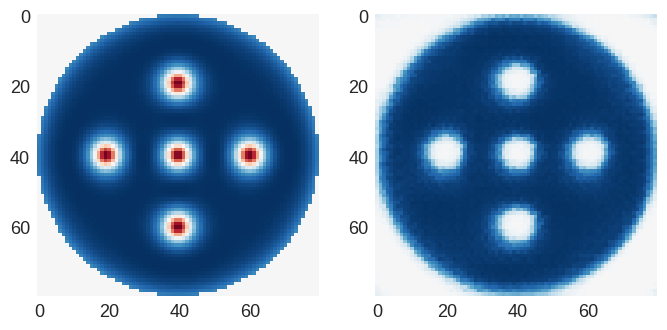

In [17]:
i = 25
in_sim = test_set[i : i + 1]
out_sim = auto_encoder(in_sim)
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].imshow(in_sim[0, ..., 2], vmin=-1, vmax=1, cmap="RdBu")
ax[1].imshow(out_sim[0, ..., 2], vmin=-1, vmax=1, cmap="RdBu")

## Feature extractor

In [22]:
feature_extractor = tf.keras.models.Sequential(
    [   # first 5 layers of the autoencoder
        auto_encoder.layers[0],
        auto_encoder.layers[1],
        auto_encoder.layers[2],
        auto_encoder.layers[3],
        auto_encoder.layers[4],
        tf.keras.layers.Flatten(),
    ]
)

feature_extractor.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_261 (Conv2D)             │ (None, 80, 80, 12)     │         2,316 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_158               │ (None, 40, 40, 12)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_262 (Conv2D)             │ (None, 40, 40, 9)      │         6,921 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_159               │ (None, 20, 20, 9)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 3600)           │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,237 (36.08 KB)

 Trainable params: 9,237 (36.08 KB)

 Non-trainable params: 0 (0.00 B)

In [29]:
feat_shape = auto_encoder.layers[4].output.shape[-1]


In [30]:
feature_arr = feature_extractor.predict(sim_arr, verbose=2)

95/95 - 2s - 18ms/step


## Clustering

In [31]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

In [32]:
neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(feature_arr)
distances, indices = neighbors_fit.kneighbors(feature_arr)

In [33]:
distances_sorted = np.sort(distances, axis=0)

In [34]:
import plotly.graph_objs as go

fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x = list(range(distances_sorted.shape[0])),
        y = distances_sorted[:, -1],
        mode="markers",
    )
)
fig.update_layout(
    autosize=False,
    width=990,
    height=300,
    margin=dict(
        l=10,
        r=10,
        b=25,
        t=25,
    ),
    xaxis_title="Instance",
    yaxis_title="Euclidian distance",
)

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'mode': 'markers',
              'type': 'scatter',
              'x': [0, 1, 2, ..., 3007, 3008, 3009],
              'y': array([2.38227767e-05, 2.39750007e-05, 2.41262642e-05, ..., 9.82420120e+01,
                          9.85068741e+01, 9.85245361e+01])}],
    'layout': {'autosize': False,
               'height': 300,
               'margin': {'b': 25, 'l': 10, 'r': 10, 't': 25},
               'template': '...',
               'width': 990,
               'xaxis': {'title': {'text': 'Instance'}},
               'yaxis': {'title': {'text': 'Euclidian distance'}}}
})

In [35]:
dbscan = DBSCAN(eps=0.64, min_samples=5)

In [36]:
dbscan.fit(feature_arr)
dbscan.labels_.max()

141

## Comparing results

In [37]:
class_dict = {f"Class {i}": list() for i in range(dbscan.labels_.max() + 1)}
class_dict["Outliers"] = list()
for index, path in enumerate(simulation_file_paths):
    class_ = dbscan.labels_[index]
    if class_ == -1:
        class_dict["Outliers"].append(str(path))
    else:
        class_dict[f"Class {class_}"].append(str(path))

In [38]:
import plotly.graph_objs as go
import plotly.express as ptx


traces = list()
for class_id, colour in zip(class_dict, ptx.colors.qualitative.Dark24):
    traces.append(
        go.Scatter(
            x=[
                parameters_dict[f]["H"]
                for f in class_dict[class_id]
            ],
            y=[
                parameters_dict[f]["E"]
                for f in class_dict[class_id]
            ],
            mode="markers",
            name=class_id,
            opacity=0.7,
            marker=dict(
                size=11,
                color=colour,
            ),
        )
    )

fig = go.Figure(data=traces)
fig.update_layout(
    autosize=False,
    width=990,
    height=600,
    margin=dict(
        l=10,
        r=10,
        b=25,
        t=25,
    ),
    xaxis_title=r"$\mu_0 \mathbf{H} \text{ (T)}$",
    yaxis_title=r"$\Delta \text{E (J)}$",
)

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'marker': {'color': '#2E91E5', 'size': 11},
              'mode': 'markers',
              'name': 'Class 0',
              'opacity': 0.7,
              'type': 'scatter',
              'x': [0.6698909203044445, 0.6698909203044445, 0.6698909203044445,
                    0.6698909203044445, 0.6698909203044445, 0.6698909203044445,
                    0.6698909203044445, 0.6699039315395161, 0.6699039315395161,
                    0.6699039315395161, 0.6699039315395161, 0.6699039315395161,
                    0.6699039315395161, 0.6699039315395161],
              'y': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
                    0.0, 0.0]},
             {'marker': {'color': '#E15F99', 'size': 11},
              'mode': 'markers',
              'name': 'Class 1',
              'opacity': 0.7,
              'type': 'scatter',
              'x': [0.55779369174165, 0.55779369174165, 0.55779369174165,
                    0.55779369174165, 0.55779369174165, 0.55779369174165,
                    0.55779369174165, 0.55779369174165],
              'y': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]},
             {'marker': {'color': '#1CA71C', 'size': 11},
              'mode': 'markers',
              'name': 'Class 2',
              'opacity': 0.7,
              'type': 'scatter',
              'x': [0.5823933515367479, 0.5823933515367479, 0.5823933515367479,
                    0.5823933515367479, 0.5823933515367479, 0.5823933515367479,
                    0.5823933515367479, 0.5823933515367479, 0.5814367798799912,
                    0.5814367798799912, 0.5814367798799912, 0.5814367798799912,
                    0.5814367798799912, 0.5814367798799912, 0.5814367798799912,
                    0.5814367798799912, 0.5785806608969681, 0.5785806608969681,
                    0.5785806608969681, 0.5785806608969681, 0.5785806608969681,
                    0.5785806608969681, 0.5785806608969681, 0.5785806608969681,
                    0.5851306000927129, 0.5851306000927129, 0.5851306000927129,
                    0.5851306000927129, 0.5851306000927129, 0.5851306000927129,
                    0.5851306000927129, 0.5851306000927129],
              'y': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
                    0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
                    0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]},
             {'marker': {'color': '#FB0D0D', 'size': 11},
              'mode': 'markers',
              'name': 'Class 3',
              'opacity': 0.7,
              'type': 'scatter',
              'x': [0.7108584663581602, 0.7108584663581602, 0.7108584663581602,
                    0.7108584663581602, 0.7108584663581602, 0.7108584663581602,
                    0.7108584663581602, 0.7125494922138771, 0.7125494922138771,
                    0.7125494922138771, 0.7125494922138771, 0.7125494922138771,
                    0.7125494922138771, 0.7125494922138771, 0.7140948789521357,
                    0.7140948789521357, 0.7140948789521357, 0.7140948789521357,
                    0.7140948789521357, 0.7140948789521357, 0.7140948789521357],
              'y': [1.5954744660000286e-19, 1.5954744660000286e-19,
                    1.5954744660000286e-19, 1.5954744660000286e-19,
                    1.5954744660000286e-19, 1.5954744660000286e-19,
                    1.5954744660000286e-19, 1.6709709300000117e-19,
                    1.6709709300000117e-19, 1.6709709300000117e-19,
                    1.6709709300000117e-19, 1.6709709300000117e-19,
                    1.6709709300000117e-19, 1.6709709300000117e-19,
                    1.7398201589999568e-19, 1.7398201589999568e-19,
                    1.7398201589999568e-19, 1.7398201589999568e-19,
                    1.7398201589999568e-19, 1.7398201589999568e-19,
                    1.7398201589999568e-19]},
             {'marker': {'color': '#DA16FF', 'size': 11},
              'mode': 'markers',
              'name': 

![Published results](images/phase-paper.jpg)